# <p style="text-align: center;">WRE Assignment </p>
<p style="text-align: center;">Mageline Duquesne, Marie Domingues Dos Santos, Romain Phan </p>

Notes: All our function are on Git4.py

In [247]:
#import Git4
import math
%run Git4.py

## <p style="color:red">Calibration </p>


 1. Report the best fit parameters for the hydrological model.

In [93]:
# Pest Parameters
# Valeur empirique trouvée par itération de l'algo

K_sat=3.5/(3600*1000) #mm/h -->m/s
c=8              # [-] exponent of ksat for the equation k = ksat * s^c
t_sub=70        # [h] mean sub-superficial residence time
z=600 #mm


 4. Plot Markov chains of the calibrated parameters and sequences of values of N S and TSA as a function of the number of iterations. Only plot accepted parameter sets.

## <p style="color:red">Hydrological variables </p>

In [58]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

 2. Plot the time series (6-year-long) of precipitation in [mm/h], run off in [mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in [mm/h] for the calibrated hydrological model forced by the given precipitation).

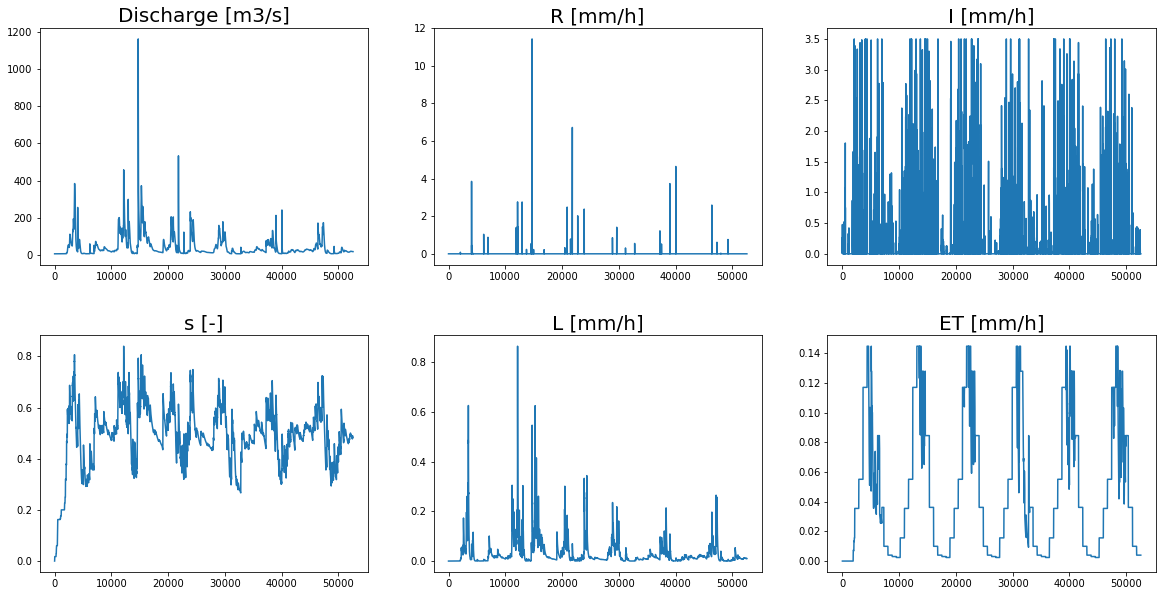

In [60]:
plot_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

## <p style="color:red"> Discharge </p>


3. Plot the time series of observed discharge and of the discharge as simulated by the
hydrological model with the best fit parameters.

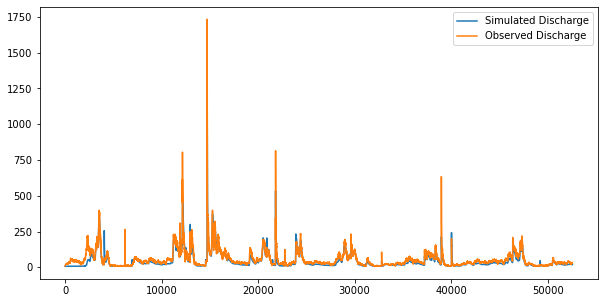

In [61]:
figure=plt.figure(figsize=(10,5))
plt.plot(Q, label="Simulated Discharge")
plt.plot(Q_obs,label="Observed Discharge")

plt.legend()

Comments: We observe that simulated and observed Discharge are quite similar, the two curves overllap well during the the six years. Howevers, pics of the Observed discharge are higher than simulated ones. That is a problem of the modelisation that tend to smooth processes

## <p style="color:red"> Generation of precipitation </p>

5. Plot the comparison between the statistics (mean, standard deviation, α and λ) of
the observed and generated precipitation

In [62]:
day_month=[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] #"day_month": number of days for each month
month_end=np.cumsum(day_month)-1                    #"month_end": last day of each month
month_start=month_end-day_month+1

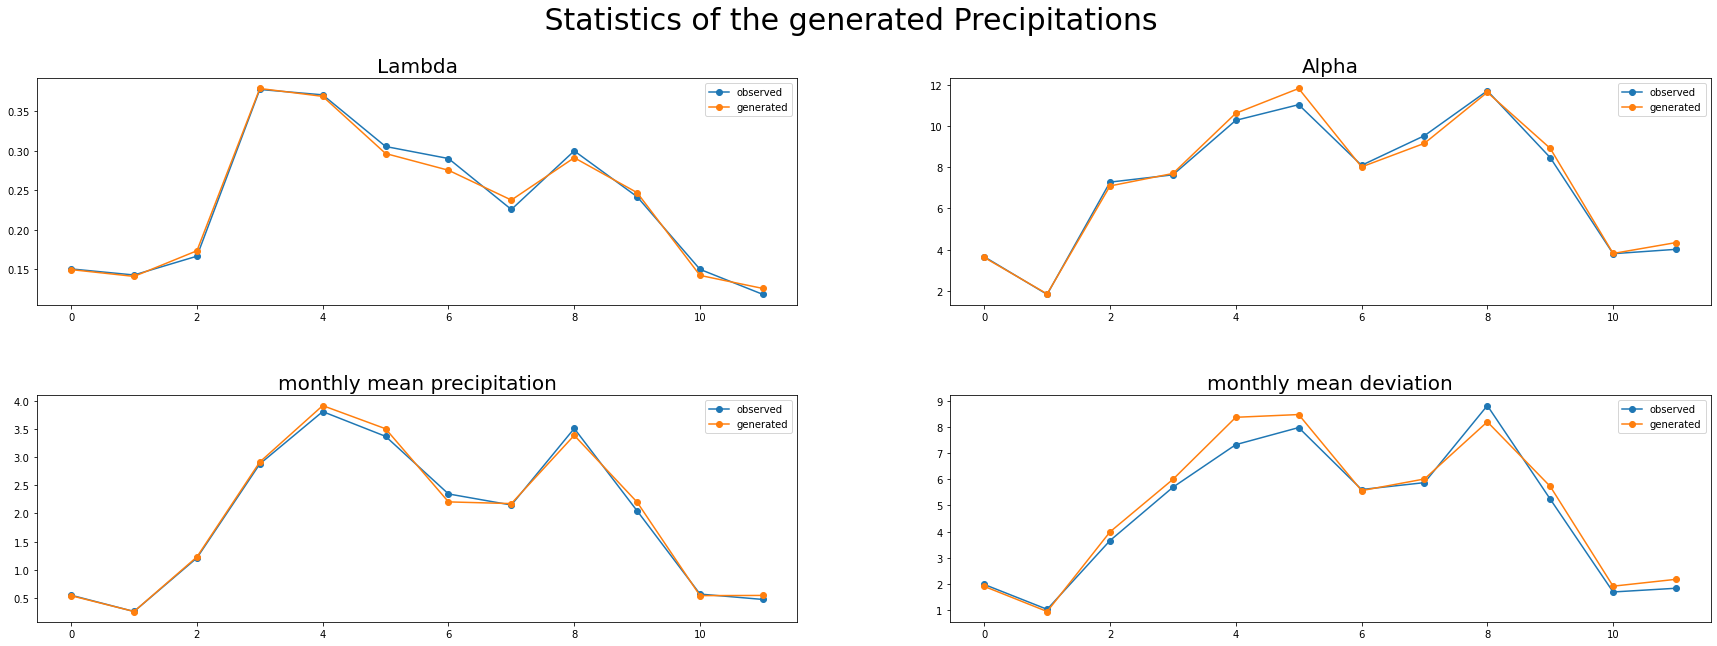

In [203]:
P=rain_gen(years=100,plot=True)

We observe a good overlapping of the different parameters.

## <p style="color:red"> Simulation of hydrological variables </p>

6. Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in
[mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotran-
spiration in [mm/h] for the calibrated hydrological model forced by the generated
precipitation)

In [64]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)


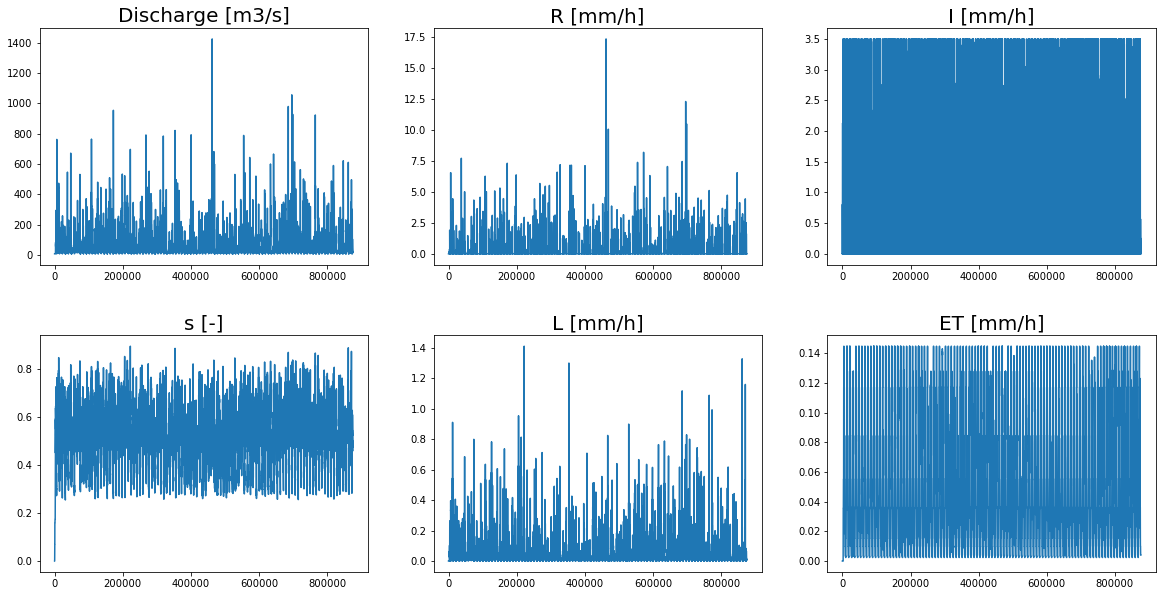

In [65]:
plot_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

## <p style="color:red"> Reservoir Area and Volume Rating curves </p>

7. Plot the area and the volume rating curves for the given levels.

Text(0.5, 1.0, 'Area Rating curve')

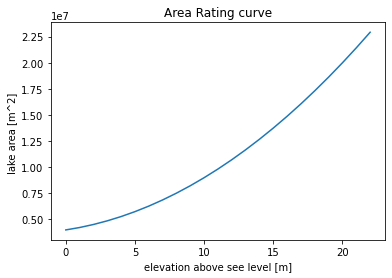

In [28]:
elevation=[k for k in range (0,23)]
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,A_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake area [m^2] ")
plt.title("Area Rating curve")

Text(0.5, 1.0, 'Volume Rating curve')

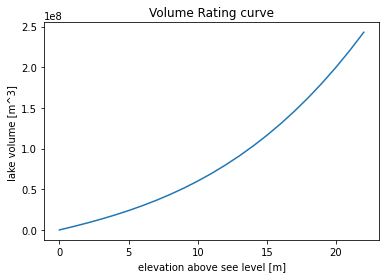

In [29]:
V_rating=vol_rat_curve(A_rating)
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,V_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake volume [m^3] ")
plt.title("Volume Rating curve")

##  <p style="color:red"> Discharge and reservoir routine </p>

8. Report the minimum flow (discharge that is equalled or exceeded 95% of the time)
of the generated discharge and plot the discharge duration curves

Q347= 7.524905201802038 m3/s


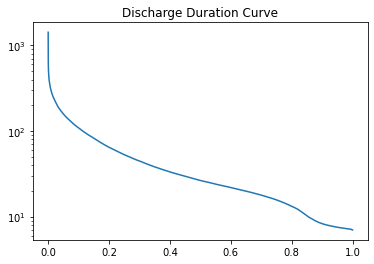

In [67]:
print("Q347= " +str(Q_347(Q, plot=True))+" m3/s") # m3/s

9. For a maximum level for hydroelectric use of 15 m, plot the time series (100 years
long) of input discharge, output discharge, volume within the reservoir and level

In [124]:
P=rain_gen(years=6,plot=False)
#Energy_price=75
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=15)

In [126]:
print("The Annual Energy Production is = "+ str(E_annual) + " GWh")

The Annual Energy Production is = 77.38902493556077 GWh


In [193]:
def plot_routine(Q,Q_out,V,l,lmaxHU):
    
    '''
        Input: Qin, Qoutn V, l
        Plot main graph of reservoir routine
    '''
    figure=plt.figure(figsize=(15,10))
    
    plt.subplot(3,1,1)
    ax=plt.gca()
    plt.plot(Q,label="Qin")
    plt.plot(Q_out,label="Qout")
    plt.ylabel("discharge [m3/s]")
    ax.legend()
    
    plt.subplot(3,1,2)
    ax=plt.gca()
    plt.plot(V)
    plt.ylabel("Volume [m3]")
    
    
    plt.subplot(3,1,3)
    ax=plt.gca()
    plt.plot()
    plt.plot([lmaxHU]*len(Q), label= "max level ",color="red",linestyle="--")
    plt.plot(l)
    
    plt.ylabel("level [m]")
    ax.legend()
    
    
    title="Reservoir routine for " +str(int(len(Q)/(365*24)))+" years and lmax = " +str(lmaxHU) + " m"
    
    plt.suptitle(title,fontsize=20)
    
    return None

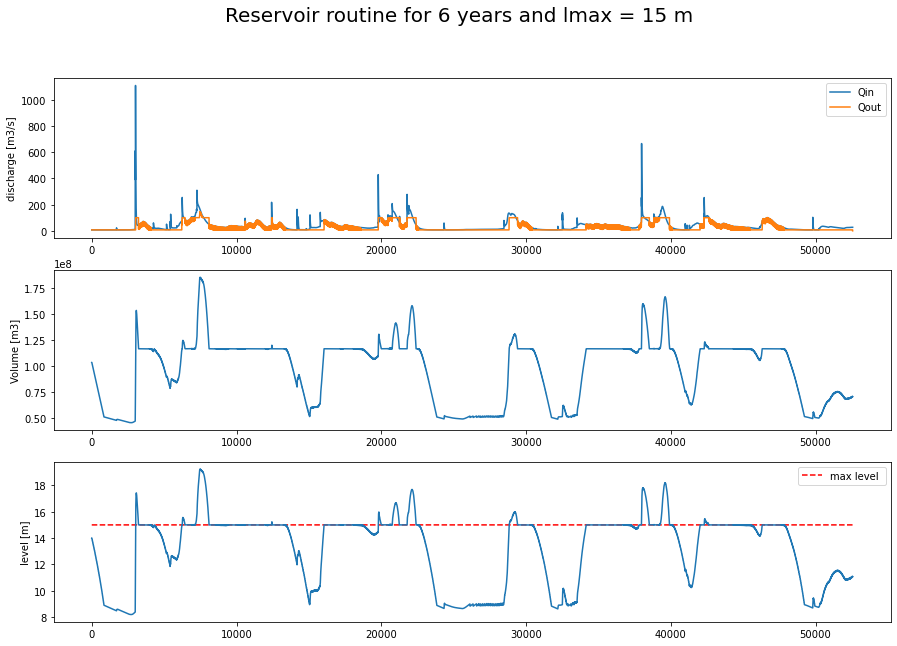

In [167]:
plot_routine(Q,Q_out,V,l,15)

10. Plot the average annual energy production in [GWh] and the probability that Qout
exceeds Qlim for different values of the maximum level for hydroelectrical use.

In [174]:
lmax=np.linspace(9,19,21)
energy=[]
money=[]
prob_flood=[]
for element in lmax:
    [V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages]=reservoir_routine(Q,P,ET,V_rating,lmax_HU=element)
    energy.append(E_annual)
    money.append(profit)
    prob_flood.append(p_flood)
    
max_money=money[0]
best_l=lmax[0]
for i in range (1,len(lmax)):
    if money[i]>max_money:
                max_money=money[i]
                best_l=lmax[i]

Text(0.5, 1.0, 'Average annual energy production')

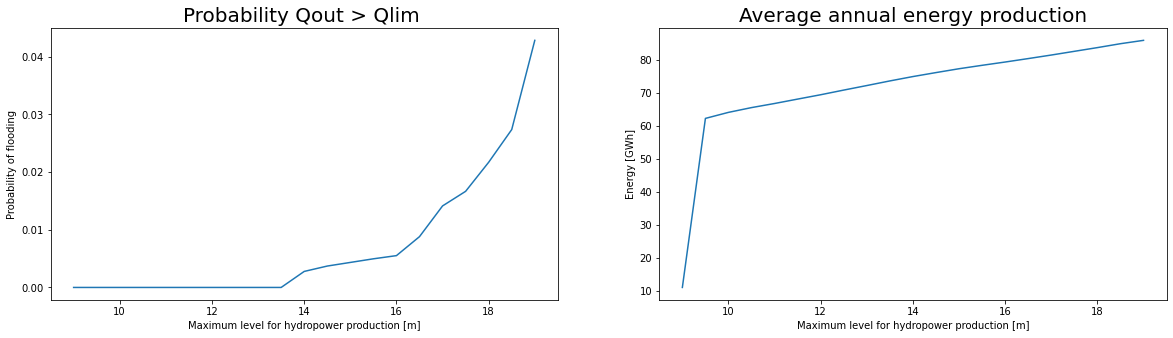

In [171]:
#plt.plot(lmax,money)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(lmax,prob_flood)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Probability of flooding")
ax.set_title("Probability Qout > Qlim ",fontsize=20)

plt.subplot(1,2,2)
plt.plot(lmax,energy)
ax=plt.gca()
plt.xlabel("Maximum level for hydropower production [m]")
plt.ylabel("Energy [GWh]")
ax.set_title("Average annual energy production",fontsize=20)

The best level for hydropower production is  17.5 m


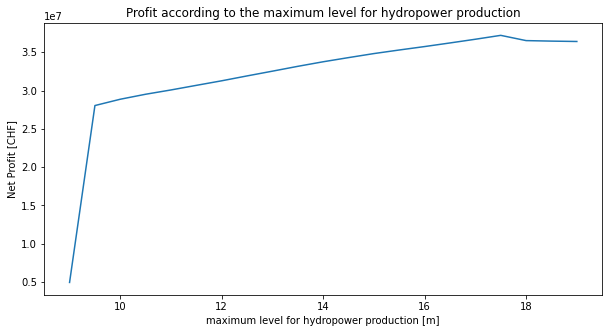

In [177]:
figure=plt.figure(figsize=(10,5))
plt.plot(lmax,money)
plt.xlabel("maximum level for hydropower production [m]")
plt.ylabel("Net Profit [CHF]")
plt.title("Profit according to the maximum level for hydropower production")

print("The best level for hydropower production is  " + str(best_l) +" m")

# REDO ! Probably a problem

##  <p style="color:red">  Climate change </p>

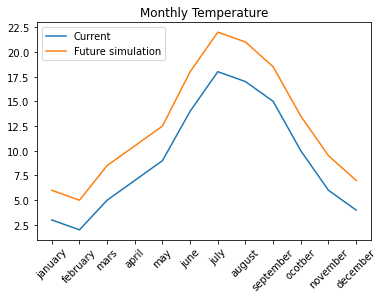

In [233]:
plt.plot(month_name,T_m,label="Current")
plt.plot(month_name,T_future,label="Future simulation")
plt.xticks(rotation=45)
plt.title("Monthly Temperature")
plt.legend()


15. Plot the comparison of the monthly statistics of rainfall and the mean monthly dis-
charge in [m3/s] computed under the current conditions and climate change conditions.

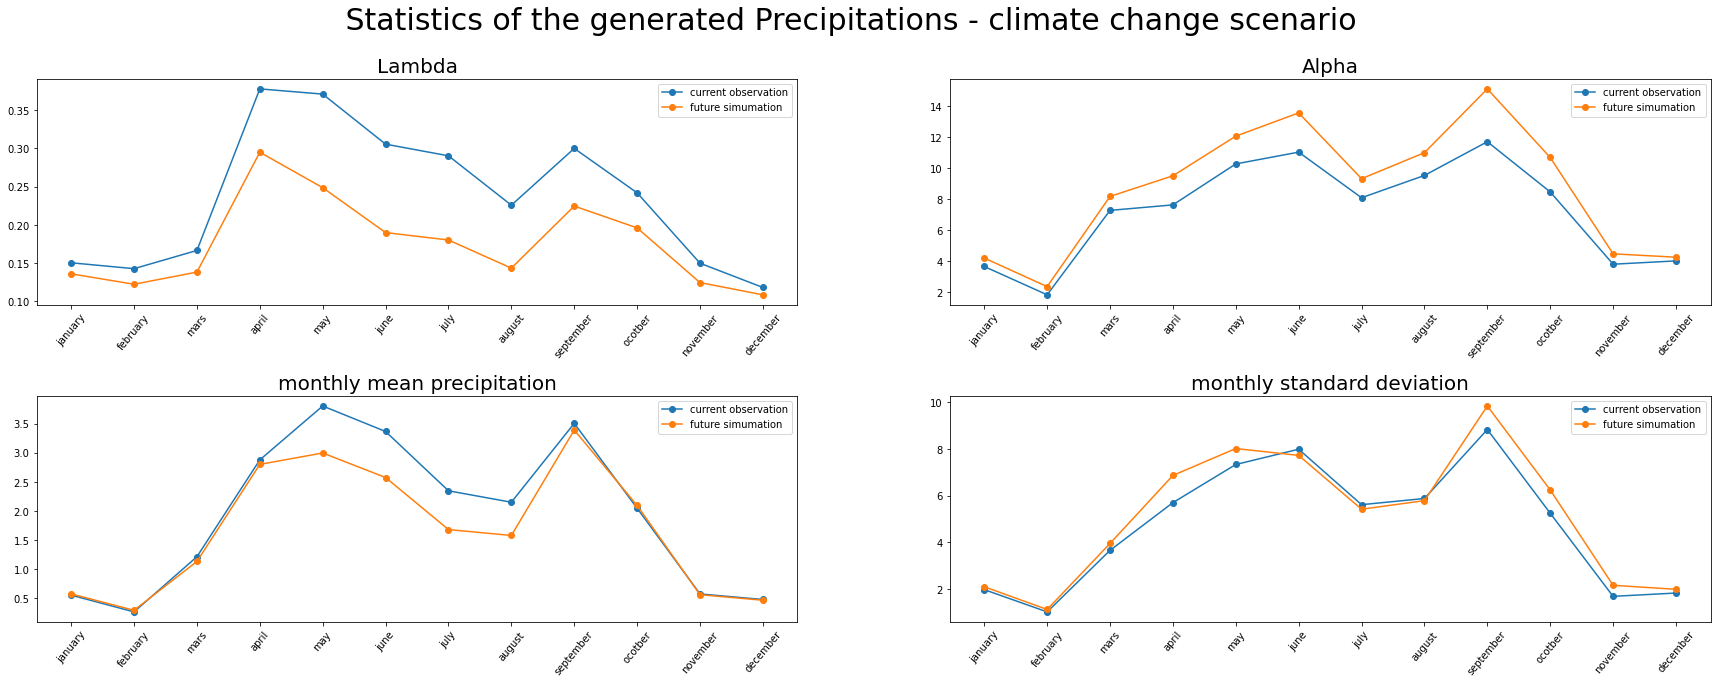

In [248]:
precipitation_change=rain_gen(years=100,plot=True,climate_change=True,alpha_c=alpha_c)


We observe that the monthly precipitation is lower in a climate change scenario, especially for months between April and September. The monthly standard

In [ ]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, precipitation_change, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0, T=T_future)


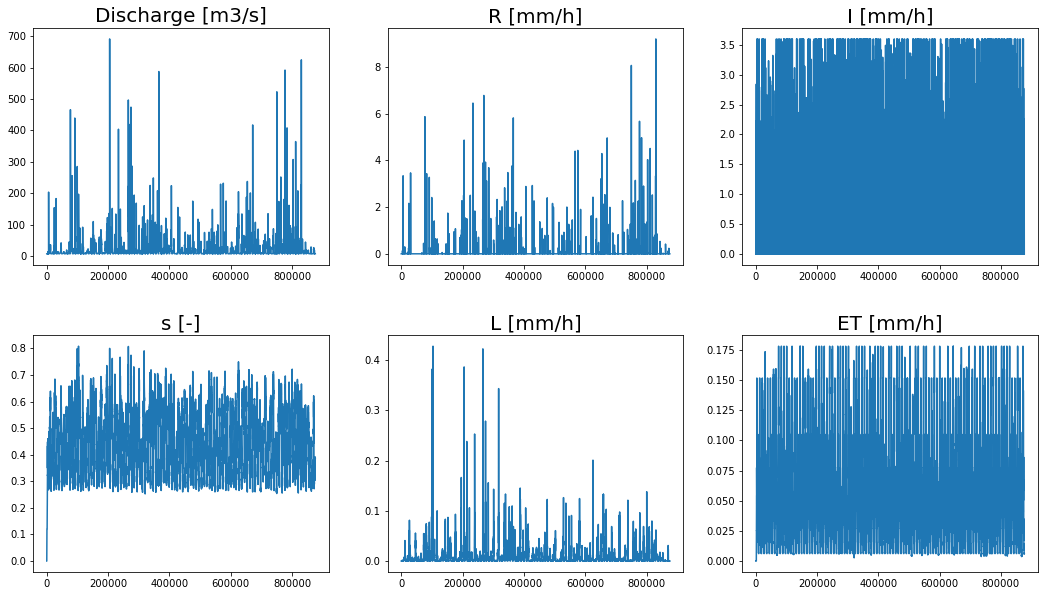

In [187]:
plot_model(K_sat, c, t_sub, z, precipitation_change, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0, T=T_future)

In [ ]:
[lambda_p, alpha, mean_P, std_P]= rain_gen(years=100,plot=True,climate_change=False,alpha_c=alpha_c, T=T_future)

In [191]:
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow,profit,p_flood,E_annual,Damages]=reservoir_routine(Q,precipitation_change,ET,V_rating,lmax_HU=15)

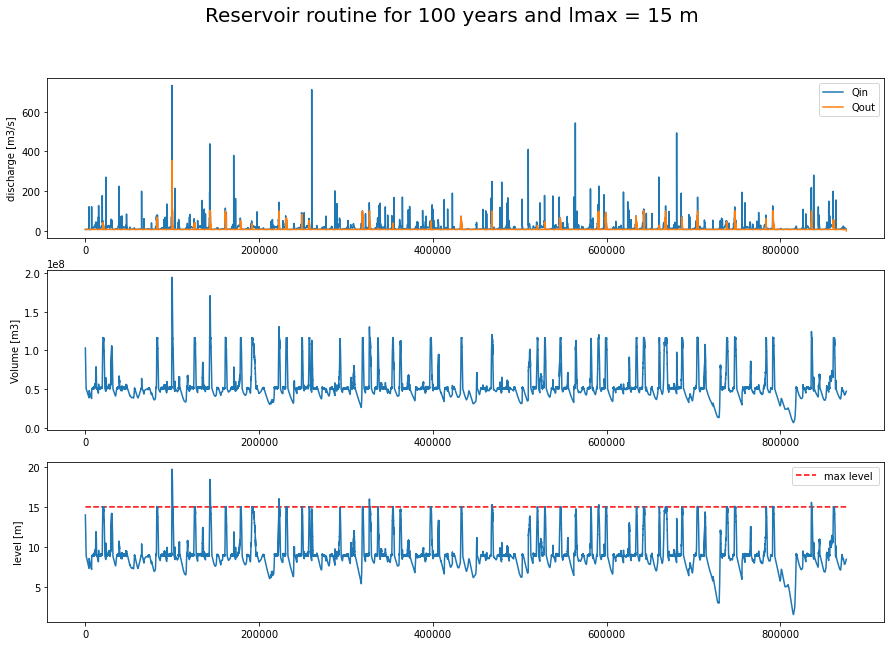

In [194]:
plot_routine(Q,Q_out,V,l,15)

16. Plot the comparison between the energy production and flooding probability under
current and climate change conditions.


17. Plot the comparison between the income function for different levels under current
and climate change conditions.


18. Elaborate on the impact of climate change on the operation of the reservoir

ASK

In [40]:
parameters

In [85]:
 ET_0(T_future)

[0.031150246075276493,
 0.03110454125795093,
 0.05411370317866318,
 0.07709960968416166,
 0.09678544948200447,
 0.1517911924918099,
 0.1781634751180459,
 0.15915888035755257,
 0.13127122196213525,
 0.08224950197659875,
 0.05334466937553971,
 0.03559499665674754]

In [197]:
lambda_c

array([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20], dtype=int64)